In [1]:
import pandas as pd
import glob
from tqdm.notebook import tqdm

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'
# Directory that contains openalex dataset
# replace this with the directory where you store your local copy of OpenAlex data
# This directory contains:
# works_open_access.csv.gz
# PaperYear.csv

DIR = '../data/study_2_data' # data pertaining to this specific research project
LARGEDATA = '../data/large'

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

PaperIDtoInt = lambda x: int(x.replace('https://openalex.org/W', ''))

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
def processWhiteRegion(row):

    r = row['region']
    sub = row['sub-region']
    country = row['country']

    if r == 'Asia' or r == 'Africa' or r=='Europe':
        return r
    elif r == 'Americas':
        return sub
    elif r == 'Oceania':
        if sub == 'Australia and New Zealand':
            return sub
        else:
            return r

def processNorthSouth(row):

    # Classify whether a country is Global North or Global South country
    # True: global south
    # False: global north

    r = row['region']
    sub = row['sub-region']
    country = row['country']

    if country == 'JP' or country == 'IL' or country == "KR":
        return False

    if r == 'Asia' or r == 'Africa':
        return True
    elif r == 'Americas':
        if sub == 'Latin America and the Caribbean':
            return True
        else: # north america
            return False
    elif r == 'Oceania':
        if sub == 'Australia and New Zealand':
            return False
        else:
            return True
    elif r == "Europe":
        return False
        

nonWhite = pd.DataFrame(
    {
        'ProcessedRegion': ['Asia', 'Africa', 'Oceania', 'Latin America and the Caribbean',
                   'Europe', 'Australia and New Zealand', 'Northern America'],
        'nonWhite': [True, True, True, True, False, False, False]
    }
)

continents = (
    pd.read_csv(f'../data/continents2.csv', usecols=['alpha-2', 'region', 'sub-region', 'name'])
    .rename(columns={'alpha-2': 'country'})
    .dropna()
    
    .assign(ProcessedRegion=lambda df: df.apply(processWhiteRegion, axis=1))
    .merge(nonWhite, on='ProcessedRegion')

    .assign(GlobalSouth=lambda df: df.apply(processNorthSouth, axis=1))
    .pipe(printShape, cols=['country'])

    .rename(columns={'country':'country_code'})
)

(247, 7)  country 247  


# Load data

## Load works metadata

In [4]:
%%time
worksOA = (
    pd.read_csv(
        f'{OPENALEX}/raw_data/works_open_access.csv.gz',
        usecols=['work_id','is_oa','oa_status']
    )
    .assign(PaperID=lambda df: df.work_id.apply(PaperIDtoInt))
    .drop(['work_id'], axis=1)
    .pipe(printShape, cols=['PaperID'])
) # 257748845

(257748845, 3)  PaperID 257748845  
CPU times: user 12min 27s, sys: 28.3 s, total: 12min 56s
Wall time: 13min 11s


In [5]:
%%time
paperYear = pd.read_csv(f'{OPENALEX}/cleaned_data/PaperYear.csv').pipe(printShape, cols=['PaperID']) # 257748845

(257748845, 2)  PaperID 257748845  
CPU times: user 2min 33s, sys: 7.25 s, total: 2min 40s
Wall time: 2min 44s


In [6]:
%%time
paperJournal = pd.read_csv(f'{OPENALEX}/cleaned_data/PaperJournal.csv', usecols=['PaperID','JournalID']).pipe(printShape, cols=['PaperID'])

(215542989, 2)  PaperID 208261724  
CPU times: user 2min 39s, sys: 8.04 s, total: 2min 47s
Wall time: 2min 52s


## Country region

In [7]:
%%time
authorCount = pd.read_csv(f'{LARGEDATA}/PaperAuthorCount.csv').pipe(printShape)

(235722554, 2)  
CPU times: user 33.6 s, sys: 3.1 s, total: 36.7 s
Wall time: 38.3 s


In [8]:
%%time
papCountry = (
    pd.read_csv(f'{LARGEDATA}/PaperCountry.csv')
    .pipe(printShape)

    .merge(authorCount, on='PaperID')
    .pipe(printShape) # 123301358

    .merge(continents, on='country_code')
    .pipe(printShape)

    .assign(Percentage=lambda df: df.AuthorCount/df.Count)
)

(123301358, 3)  
(123301358, 4)  
(123290382, 10)  
CPU times: user 1min 48s, sys: 19.9 s, total: 2min 8s
Wall time: 2min 15s


In [9]:
%%time
papCountryAll = papCountry.query('Percentage == 1')

CPU times: user 6.74 s, sys: 2.09 s, total: 8.83 s
Wall time: 16 s


In [10]:
papCountryAll.shape # 66490833

(66490833, 11)

In [ ]:
%%time
citedByCountry = (
    pd.read_csv(f'{OPENALEX}/cleaned_data/PaperCitedByCountry.csv')
    .pipe(printShape)
    .rename(columns={'CitedPaperID':'PaperID'})

    .merge(paperYear, on='PaperID')
    .pipe(printShape)

    .merge(worksOA, on='PaperID')
    .pipe(printShape)
) # 1720877675

(1732900045, 3)  
(1720877675, 4)  


In [ ]:
citedByCountry.info()

In [ ]:
citedByCountry.head()

In [ ]:
continents.head()

In [ ]:
%%time
allPapers = (
    citedByCountry.drop(['country_code', 'count'], axis=1).drop_duplicates()
    .pipe(printShape, cols=['PaperID']) # 86042813
)

In [ ]:
%%time
paperCitedByGlobalSouth = (
    citedByCountry.merge(continents[['country_code','GlobalSouth']].query('GlobalSouth==True'), on='country_code')
    .pipe(printShape) # 529418718
)

In [ ]:
%%time
paperCitedByGlobalSouthCount = (
    paperCitedByGlobalSouth.groupby('PaperID')['count'].sum().reset_index()
    .pipe(printShape, cols=['PaperID'])
)

In [ ]:
%%time
paperCitedByGlobalSouthLogit = (
    allPapers.merge(paperCitedByGlobalSouth[['PaperID']].drop_duplicates().assign(CitedByGlobalSouth=1), on='PaperID', how='left')
    .fillna({'CitedByGlobalSouth': 0})
)

In [ ]:
%%time
paperCitedByGlobalSouthOLS = (
    allPapers.merge(paperCitedByGlobalSouthCount, on='PaperID', how='left')
    .fillna({'count': 0})
)

In [4]:
from statsmodels.formula.api import ols, logit
from scipy.stats import ttest_ind
from statsmodels.iolib.summary2 import summary_col

In [24]:
paperCitedByGlobalSouthLogit.head()

,PaperID,Year,is_oa,oa_status,CitedByGlobalSouth
0,285,2012,True,hybrid,1.0
1,290,1986,False,closed,0.0
2,504,1986,False,closed,1.0
3,524,2002,False,closed,1.0
4,536,2003,False,closed,0.0


In [30]:
paperCitedByGlobalSouthOLS.head()

,PaperID,Year,is_oa,oa_status,count
0,285,2012,True,hybrid,23.0
1,290,1986,False,closed,0.0
2,504,1986,False,closed,9.0
3,524,2002,False,closed,9.0
4,536,2003,False,closed,0.0


In [30]:
paperCitedByGlobalSouthToRegress.head()

,PaperID,Year,is_oa,CitedByGlobalSouth
0,285,2012,True,1.0
1,290,1986,False,0.0
2,504,1986,False,1.0
3,524,2002,False,1.0
4,536,2003,False,0.0


In [31]:
paperCitedByGlobalSouthToRegress.dtypes

PaperID                 int64
Year                    int64
is_oa                    bool
CitedByGlobalSouth    float64
dtype: object

In [28]:
%%time
m1 = logit('CitedByGlobalSouth ~ is_oa', data=paperCitedByGlobalSouthLogit).fit()
m2 = logit('CitedByGlobalSouth ~ Year + is_oa', data=paperCitedByGlobalSouthLogit).fit()

Optimization terminated successfully.
         Current function value: 0.610177
         Iterations 5
         Current function value: 0.587941
         Iterations: 35
CPU times: user 6min 39s, sys: 52.9 s, total: 7min 31s
Wall time: 10min 32s


/scratch/fl1092/conda-envs/pandas/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
summary_col([m1, m2], stars=True)

,CitedByGlobalSouth I,CitedByGlobalSouth II
Intercept,0.6702***,-49.5454***
,(0.0003),(0.0271)
is_oa[T.True],0.4859***,0.2733***
,(0.0005),(0.0005)
Year,,0.0251***
,,(0.0000)


In [31]:
%%time
m3 = ols('count ~ is_oa', data=paperCitedByGlobalSouthOLS).fit()
m4 = ols('count ~ Year + is_oa', data=paperCitedByGlobalSouthOLS).fit()

CPU times: user 39 s, sys: 4.93 s, total: 43.9 s
Wall time: 1min 28s


In [32]:
summary_col([m3, m4], stars=True)

,count I,count II
Intercept,7.7790***,-154.2464***
,(0.0079),(0.7051)
is_oa[T.True],2.3154***,1.6029***
,(0.0137),(0.0140)
Year,,0.0810***
,,(0.0004)
R-squared,0.0003,0.0009
R-squared Adj.,0.0003,0.0009


In [32]:
%%time
m1 = ols('CitedByGlobalSouth ~ is_oa', data=paperCitedByGlobalSouthToRegress).fit()
m2 = ols('CitedByGlobalSouth ~ Year + is_oa', data=paperCitedByGlobalSouthToRegress).fit()

CPU times: user 38.8 s, sys: 3.74 s, total: 42.5 s
Wall time: 42.8 s


In [33]:
summary_col([m1, m2], stars=True)

,CitedByGlobalSouth I,CitedByGlobalSouth II
Intercept,0.6615***,-10.1750***
,(0.0001),(0.0053)
is_oa[T.True],0.0991***,0.0514***
,(0.0001),(0.0001)
Year,,0.0054***
,,(0.0000)
R-squared,0.0103,0.0565
R-squared Adj.,0.0103,0.0565


In [34]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     CitedByGlobalSouth   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                 8.930e+05
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:23:35   Log-Likelihood:            -5.4945e+07
No. Observations:            86042813   AIC:                         1.099e+08
Df Residuals:                86042811   BIC:                         1.099e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6615   6.05e-05   1.09e+04      0.000       0.661       0.662
is_oa[T.True]     0.0991      0.000    944.972      0.000       0.099       0.099
==============================================================================
Omnibus:                169817654.666   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15604805.767
Skew:                          -0.830   Prob(JB):                         0.00
Kurtosis:                       1.736   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
paperCitedByGlobalSouthToRegress.head()

,PaperID,Year,is_oa,CitedByGlobalSouth
0,285,2012,True,True
1,290,1986,False,False
2,504,1986,False,True
3,524,2002,False,True
4,536,2003,False,False


### oa country count

In [92]:
%%time
OACountryCount = citedByCountry.groupby(['is_oa', 'country_code', 'Year']).PaperID.nunique().reset_index()#.rename(columns={'CitedPaperID':'PaperID'}).merge(worksOA, on='PaperID')

CPU times: user 10min 50s, sys: 32.1 s, total: 11min 22s
Wall time: 11min 55s


In [94]:
%%time
OAPaperCount = citedByCountry.groupby(['is_oa','Year']).PaperID.nunique().reset_index()#.rename(columns={'CitedPaperID':'PaperID'}).merge(worksOA, on='PaperID').

CPU times: user 4min 21s, sys: 16.1 s, total: 4min 38s
Wall time: 4min 40s


In [93]:
OAPaperCount.head()

,is_oa,Year,PaperID
0,False,208,1
1,False,1393,1
2,False,1400,64
3,False,1479,1
4,False,1481,1


In [95]:
%%time
OACountryCount.to_csv('/scratch/fl1092/Email_project/data/OACountryCount.csv', index=False)
OAPaperCount.to_csv('/scratch/fl1092/Email_project/data/OAPaperCount.csv', index=False)

CPU times: user 104 ms, sys: 3.11 ms, total: 107 ms
Wall time: 113 ms


### Plot temporal Gini index

In [3]:
%%time
OACountryCount = pd.read_csv('/scratch/fl1092/Email_project/data/OACountryCount.csv')
OAPaperCount = pd.read_csv('/scratch/fl1092/Email_project/data/OAPaperCount.csv')

print(OACountryCount.shape, OAPaperCount.shape)

(84404, 4) (961, 3)
CPU times: user 19.3 ms, sys: 8.63 ms, total: 27.9 ms
Wall time: 31.9 ms


In [4]:
OACountryCount.head()

,is_oa,country_code,Year,PaperID
0,False,AD,1830,1
1,False,AD,1847,1
2,False,AD,1881,1
3,False,AD,1893,1
4,False,AD,1910,2


In [5]:
OAPaperCount.head()

,is_oa,Year,PaperID
0,False,208,1
1,False,1393,1
2,False,1400,64
3,False,1479,1
4,False,1481,1


In [39]:
distribution = (
    OACountryCount.rename(columns={'PaperID':'Count'})
    .merge(OAPaperCount.rename(columns={'PaperID':'Total'}), on='is_oa')
    .assign(Percent=lambda df: df.Count / df.Total)
    .assign(IsNotOA=lambda df: df.is_oa.apply(lambda x: not x))
)

In [63]:
countryDiff = pd.merge(
    distribution.query('is_oa==False').drop('is_oa', axis=1).rename(columns={'Percent':'NotOAPercent'}),
    distribution.query('is_oa==True').drop('is_oa', axis=1).rename(columns={'Percent':'OAPercent'}),
    on='country_code'
).assign(Diff=lambda df: df.OAPercent/df.NotOAPercent)

In [67]:
countryDiff.sort_values(by='Diff').head(10)

,country_code,Count_x,Total_x,NotOAPercent,IsNotOA_x,Count_y,Total_y,OAPercent,IsNotOA_y,Diff
216,VG,32857,57409179,0.000572,True,4246,28633634,0.000148,False,0.259094
153,NU,558,57409179,0.000010,True,271,28633634,0.000009,False,0.973733
94,IM,6767,57409179,0.000118,True,3308,28633634,0.000116,False,0.980109
55,DZ,1045983,57409179,0.018220,True,511755,28633634,0.017873,False,0.980940
210,US,34524668,57409179,0.601379,True,17317974,28633634,0.604812,False,1.005709
117,LI,36613,57409179,0.000638,True,18459,28633634,0.000645,False,1.010829
70,GB,20535145,57409179,0.357698,True,11502155,28633634,0.401701,False,1.123017
12,AX,382,57409179,0.000007,True,214,28633634,0.000007,False,1.123195
201,TN,1250563,57409179,0.021783,True,705855,28633634,0.024651,False,1.131657
33,CA,14800941,57409179,0.257815,True,8387072,28633634,0.292910,False,1.136124


In [77]:
countryDiff.merge(continents, on='country_code').sort_values(by='Diff').tail(10)

,country_code,Count_x,Total_x,NotOAPercent,IsNotOA_x,Count_y,Total_y,OAPercent,IsNotOA_y,Diff,name,region,sub-region,nonWhite
108,KN,27104,57409179,4.721196e-04,True,35059,28633634,0.001224,False,2.593409,Saint Kitts and Nevis,Latin America and the Caribbean,Latin America and the Caribbean,True
78,GN,14295,57409179,2.490020e-04,True,18569,28633634,0.000649,False,2.604409,Guinea,Africa,Sub-Saharan Africa,True
112,KY,8718,57409179,1.518572e-04,True,11551,28633634,0.000403,False,2.656486,Cayman Islands,Latin America and the Caribbean,Latin America and the Caribbean,True
116,LC,3332,57409179,5.803950e-05,True,4484,28633634,0.000157,False,2.698146,Saint Lucia,Latin America and the Caribbean,Latin America and the Caribbean,True
189,ST,25678,57409179,4.472804e-04,True,35528,28633634,0.001241,False,2.774051,Sao Tome and Principe,Africa,Sub-Saharan Africa,True
191,SX,4681,57409179,8.153748e-05,True,6633,28633634,0.000232,False,2.841033,Sint Maarten (Dutch part),Latin America and the Caribbean,Latin America and the Caribbean,True
77,GM,40409,57409179,7.038770e-04,True,59145,28633634,0.002066,False,2.934572,Gambia,Africa,Sub-Saharan Africa,True
80,GQ,1771,57409179,3.084873e-05,True,2995,28633634,0.000105,False,3.390651,Equatorial Guinea,Africa,Sub-Saharan Africa,True
39,CK,54,57409179,9.406161e-07,True,112,28633634,0.000004,False,4.158427,Cook Islands,Oceania,Polynesia,True
26,BQ,52,57409179,9.057785e-07,True,112,28633634,0.000004,False,4.318367,"Bonaire, Sint Eustatius and Saba",Latin America and the Caribbean,Latin America and the Caribbean,True


In [27]:
import seaborn as sns
from matplotlib import pyplot as plt

<Axes: xlabel='country_code', ylabel='Percent'>

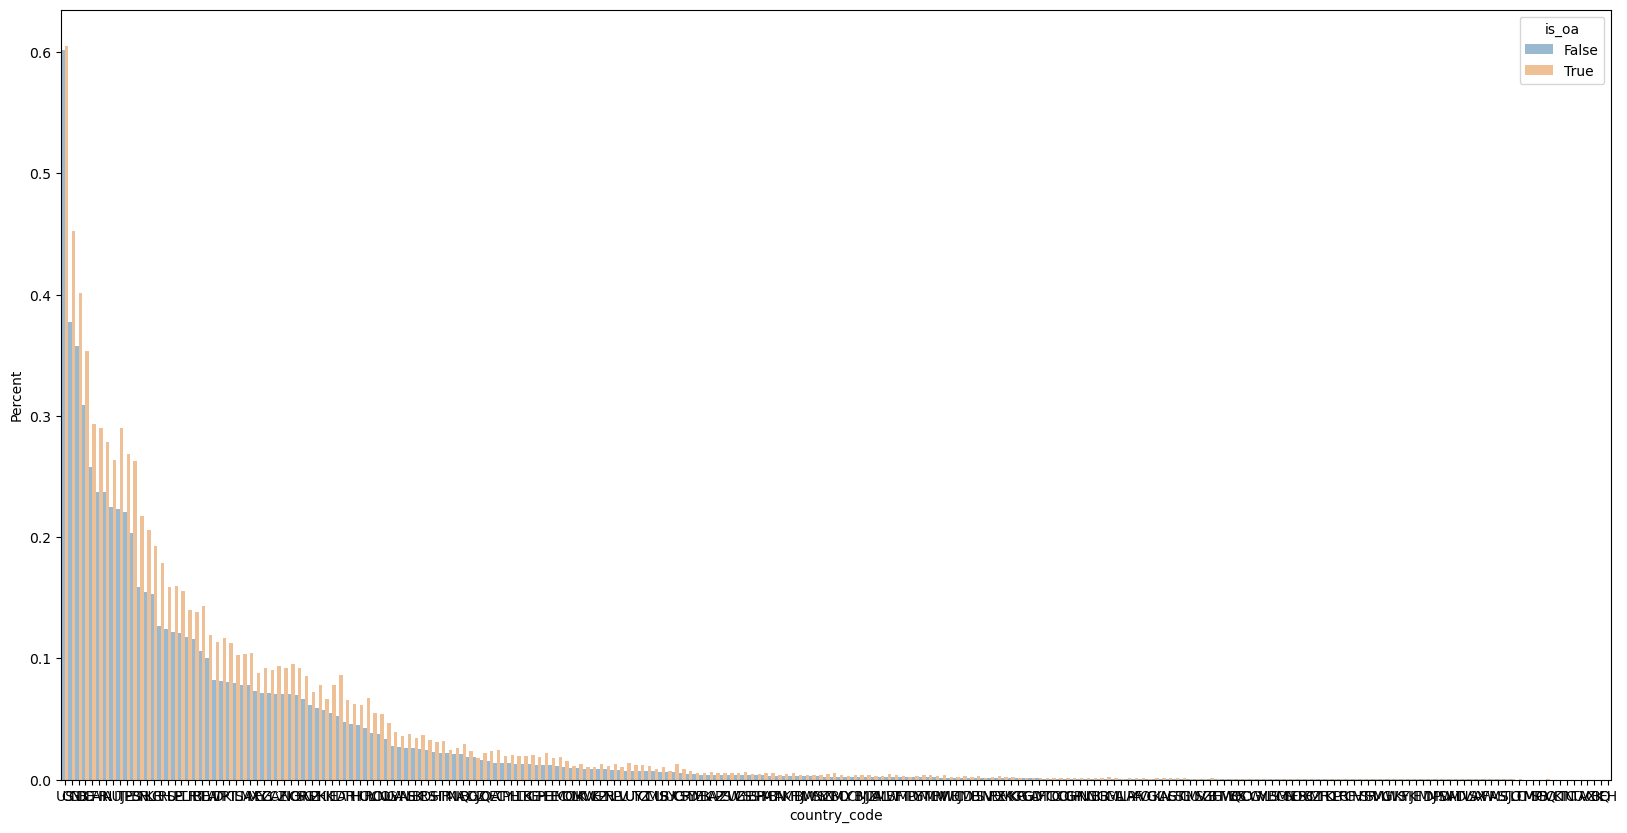

In [72]:
plt.figure(figsize=(20, 10))
sns.barplot(data=distribution.sort_values(by=['IsNotOA', 'Percent'], ascending=False), x='country_code', y='Percent', hue='is_oa', width=1, alpha=0.5)

(np.float64(-0.5), np.float64(225.5))


(0.0, 0.04)

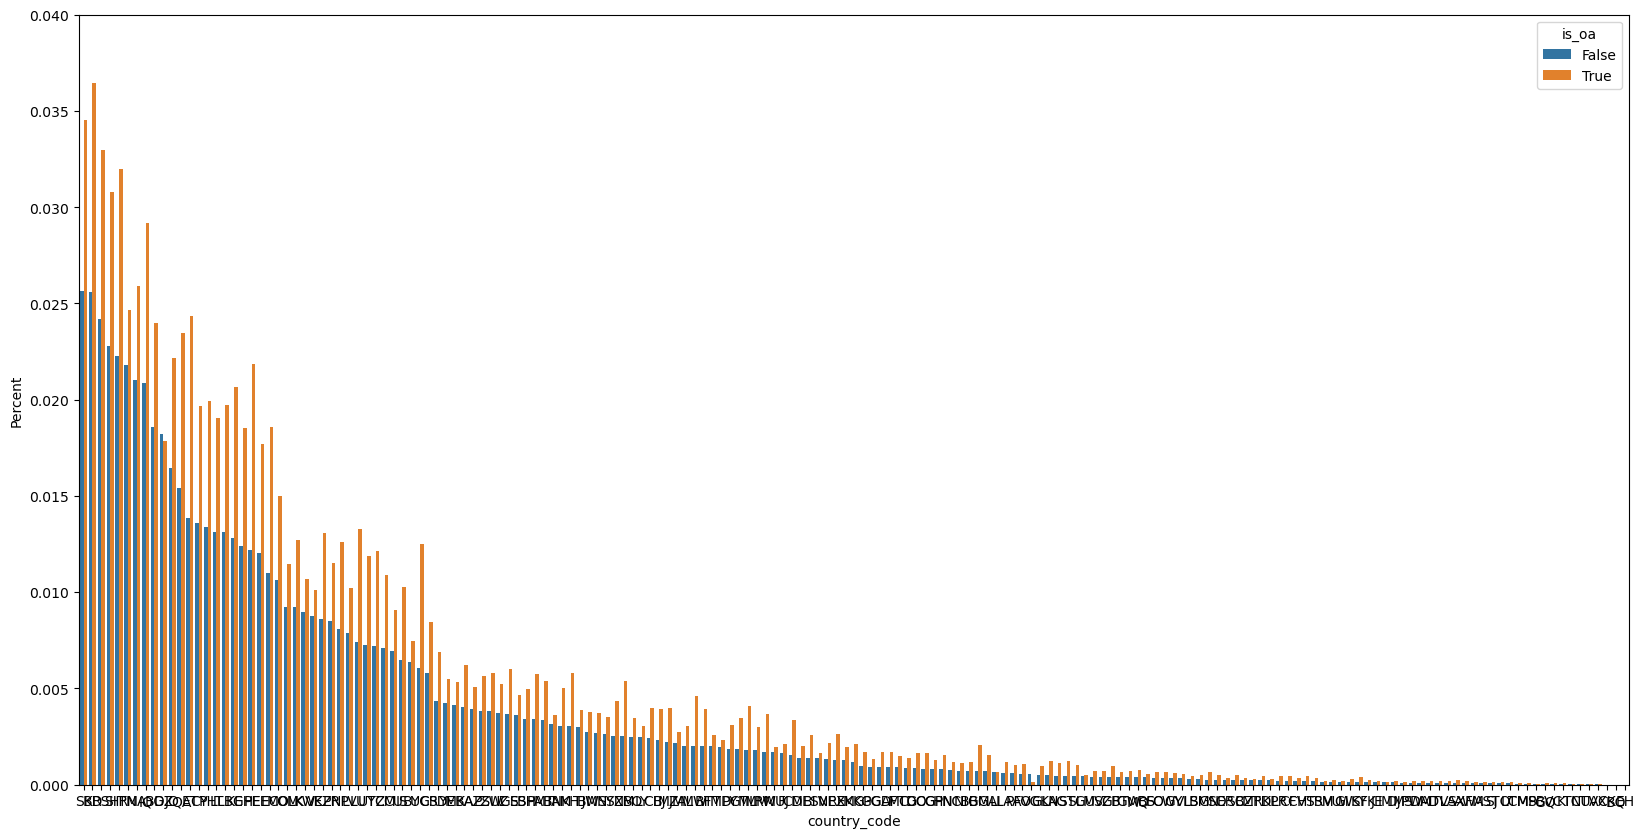

In [57]:
plt.figure(figsize=(20, 10))
sns.barplot(data=distribution.sort_values(by=['IsNotOA', 'Percent'], ascending=False), x='country_code', y='Percent', hue='is_oa')

print(plt.gca().get_xlim())
plt.gca().set_xlim(50.5, 225.5)
plt.gca().set_ylim(0, 0.04)

<Axes: xlabel='country_code', ylabel='Percent'>

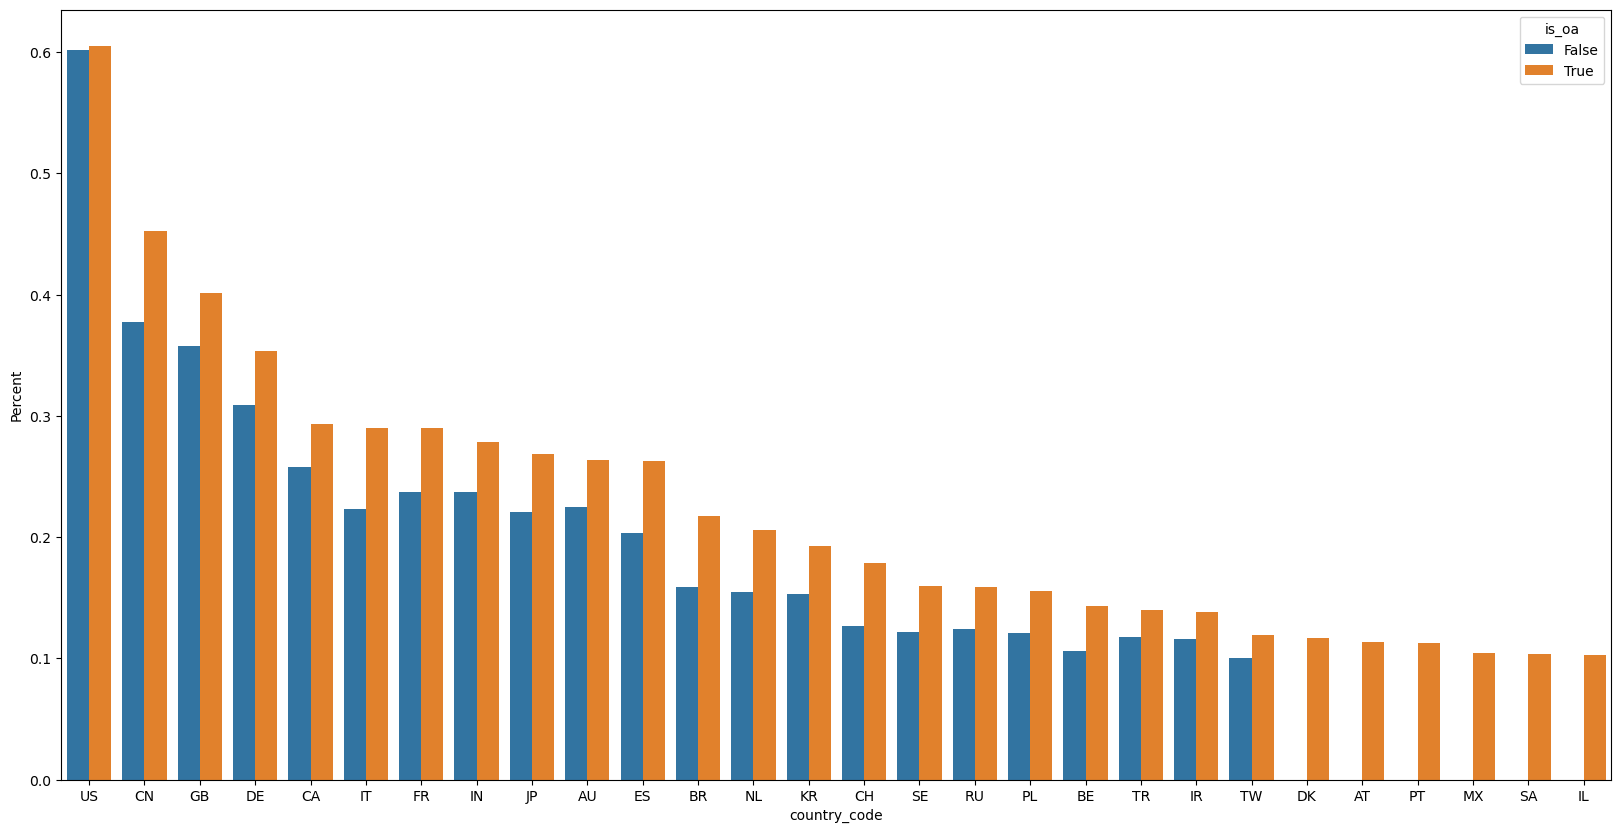

In [37]:
plt.figure(figsize=(20, 10))
sns.barplot(data=distribution.sort_values(by='Percent', ascending=False).query('Percent > 0.1'), x='country_code', y='Percent', hue='is_oa')

In [12]:
OACountryCount.head()

,is_oa,country_code,PaperID
0,False,AD,5746
1,False,AE,1507834
2,False,AF,52928
3,False,AG,26326
4,False,AL,115844


In [13]:
OAPaperCount.head()

,is_oa,PaperID
0,False,57409179
1,True,28633634


In [32]:
import numpy as np

# https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
def calcGini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [7]:
OAPaperCount.head()

,is_oa,Year,PaperID
0,False,208,1
1,False,1393,1
2,False,1400,64
3,False,1479,1
4,False,1481,1


In [9]:
OACountryCount.head()

,is_oa,country_code,Year,PaperID
0,False,AD,1830,1
1,False,AD,1847,1
2,False,AD,1881,1
3,False,AD,1893,1
4,False,AD,1910,2


In [121]:
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter1d

In [157]:
distribution = (
    OACountryCount.rename(columns={'PaperID':'Count'}).pipe(printShape)
    
    .merge(OAPaperCount.rename(columns={'PaperID':'Total'}), on=['is_oa', 'Year'])
    .pipe(printShape)
    
    .assign(Percent=lambda df: df.Count/df.Total)

    .query('Year > 1922')
    .query('Year <= 2020')
    .pipe(printShape)
)

giniOverTime = []

for ind, df in tqdm(distribution.groupby(['is_oa','Year'])):
    
    OA, year = ind
    gini = calcGini(df.Percent.values)
    
    giniOverTime.append({
        'is_oa': OA,
        'Year': year,
        'Gini': gini
    })
giniOverTime = pd.DataFrame(giniOverTime).sort_values(by=['Year'])

(84404, 4)  
(84404, 5)  
(41919, 6)  


  0%|          | 0/196 [00:00<?, ?it/s]

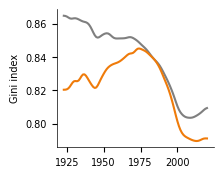

In [226]:

ax = plt.gca()

notOAx = giniOverTime.query('is_oa==False').Year.values
notOAy = giniOverTime.query('is_oa==False').Gini.values

notOAsmooth = gaussian_filter1d(notOAy, sigma=2)


OAx = giniOverTime.query('is_oa==True').Year.values
OAy = giniOverTime.query('is_oa==True').Gini.values

OAsmooth = gaussian_filter1d(OAy, sigma=2)

ax.plot(notOAx, notOAsmooth, color='#7f7f7f')
ax.plot(OAx, OAsmooth, color='#ef7b0a')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Gini index')

set_size(4*cm, 3.5*cm, ax)

plt.savefig('../figures/Gini_index.pdf', bbox_inches = 'tight', pad_inches = 0)

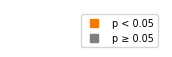

In [151]:
from matplotlib.lines import Line2D

cm = 1/2.54
legend_elements = [
    Line2D([0], [0], color='#ef7b0a', marker='s', lw=0, label='p < 0.05'),
    Line2D([0], [0], color='#7f7f7f', marker='s', lw=0, label='p ≥ 0.05')
]

fig = plt.figure(figsize=(5*cm, 1*cm))
ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right', ncol=1)
ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('../figures/pval_legend.pdf',bbox_inches = 'tight', pad_inches = 0)

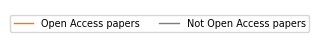

In [244]:
from matplotlib.lines import Line2D

cm = 1/2.54
legend_elements = [
    Line2D([0], [0], color='#ef7b0a', lw=1, label='Open Access papers'),
    Line2D([0], [0], color='#7f7f7f', lw=1, label='Not Open Access papers')
]

fig = plt.figure(figsize=(5*cm, 1*cm))
ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right', ncol=2)
ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('../figures/gini_index_legend.pdf',bbox_inches = 'tight', pad_inches = 0)

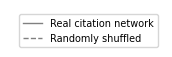

In [235]:
from matplotlib.lines import Line2D

cm = 1/2.54
legend_elements = [
    Line2D([0], [0], color='grey', lw=1, label='Real citation network'),
    Line2D([0], [0], color='grey', lw=1, label='Randomly shuffled', ls='--')
]

fig = plt.figure(figsize=(5*cm, 1*cm))
ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right', ncol=1)
ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('../figures/randomized_legend.pdf',bbox_inches = 'tight', pad_inches = 0)

In [160]:
calcGini(distribution.query('Year==2020').query('is_oa == True').Count.values)

np.float64(0.7882859146055894)

In [161]:
calcGini(distribution.query('Year==2020').query('is_oa == False').Count.values)

np.float64(0.810536799173576)

In [149]:
agg = distribution.groupby(['is_oa', 'country_code']).Count.sum().reset_index()

In [151]:
calcGini(agg.query('is_oa == True').Count.values)

np.float64(0.7957359602709482)

In [152]:
calcGini(agg.query('is_oa == False').Count.values)

np.float64(0.8140032290809406)

In [79]:
gini(distribution.query('is_oa == True').Count.values)

np.float64(0.7972725878219167)

In [80]:
gini(distribution.query('is_oa == False').Count.values)

np.float64(0.8144133542410799)

In [33]:
gini(distribution.query('is_oa == True').Percent.values)

np.float64(0.797272587821917)

In [34]:
gini(distribution.query('is_oa == False').Percent.values) # higher inequality

np.float64(0.8144133542410797)

In [ ]:
# seems like only marginally better, but what are the countries affected?

Number of citations a paper devotes to OA papers and paywalled papers

In [45]:
def CitedOA(ref):

    return (
        ref
        .assign(CitingPaperID=lambda df: df.work_id.apply(PaperIDtoInt))
        .assign(CitedPaperID=lambda df: df.referenced_work_id.apply(PaperIDtoInt))
        .drop(['work_id','referenced_work_id'], axis=1)

        .merge(worksOA.rename(columns={'PaperID':'CitedPaperID'}), on='CitedPaperID')
        .groupby(['CitingPaperID']).is_oa.value_counts().reset_index()
    )

In [ ]:
%%time
refIte = pd.read_csv(f'{OPENALEX}/raw_data/works_referenced_works.csv.gz', compression='gzip', iterator=True, chunksize=10000000)

countryOA = pd.concat([CitedOA(ref) for ref in tqdm(refIte)], ignore_index=True, sort=False) # 8h

0it [00:00, ?it/s]

In [59]:
countryOA.shape

(155981427, 3)

In [60]:
countryOA.head() # for each citing paper, number of cited papers that are OA (True) and not OA (False), respetively

,CitingPaperID,is_oa,count
0,1541232,False,28
1,1541232,True,28
2,1986919,False,77
3,1986919,True,4
4,2062081,False,4


In [61]:
countryOA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155981427 entries, 0 to 155981426
Data columns (total 3 columns):
 #   Column         Dtype
---  ------         -----
 0   CitingPaperID  int64
 1   is_oa          bool 
 2   count          int64
dtypes: bool(1), int64(2)
memory usage: 2.5 GB


In [ ]:
countryOA.to_csv('../data/PaperCitingOACount.csv',index=False)

In [ ]:
# percentage of countries' citation towards OA papers - percentage of citation towards paywalled papers
# on the country level and sub-region-level
# region level: bar plot (show baseline, of all citations, how many are made towards OA-papers and how many are made towards non-OA papers

# Get region of OA citations

In [11]:
%%time
paperOA = (
    pd.read_csv(f'{LARGEDATA}/PaperCitingOACount.csv')
    .pipe(printShape) # 155981427
    .groupby(['CitingPaperID','is_oa'])['count'].sum().reset_index()
    .pipe(printShape) # 155981044
)

(155981427, 3)  
(155981044, 3)  
CPU times: user 3min 22s, sys: 18.2 s, total: 3min 40s
Wall time: 3min 48s


In [12]:
assert(paperOA.duplicated(subset=['CitingPaperID','is_oa']).any() == False)

In [13]:
%%time
paperCitesOA = (
    paperOA.query('is_oa == True')
    [['CitingPaperID']]
    .rename(columns={'CitingPaperID':'PaperID'})
    .pipe(printShape, cols=['PaperID']) # 71458673, 71458673
)

(71458673, 1)  PaperID 71458673  
CPU times: user 28 s, sys: 2.97 s, total: 31 s
Wall time: 31.4 s


In [14]:
%%time
paperTotalCites = paperOA.groupby('CitingPaperID')['count'].sum().reset_index().rename(columns={'count': 'Total'})

paperCitesOAPercentage = (
    paperOA.query('is_oa == False')
    .merge(paperTotalCites, on='CitingPaperID', how='right')
    .fillna({'count': 0})
    
    .assign(PercentNonOA=lambda df: df['count'] / df.Total)
    .rename(columns={'CitingPaperID':'PaperID'})
    .pipe(printShape, cols=['PaperID']) # (87336219, 5)  PaperID 87336219  
)

(87336219, 5)  PaperID 87336219  
CPU times: user 1min 31s, sys: 13 s, total: 1min 44s
Wall time: 1min 46s


In [15]:
%%time
papOAYear = (
    pd.merge(
        paperOA.query('is_oa==True').rename(columns={'count':'OACount'}).pipe(printShape, cols=['CitingPaperID'], msg='OA'),
        paperOA.query('is_oa==False').rename(columns={'count':'nonOACount'}).pipe(printShape, cols=['CitingPaperID'], msg='not OA'),
        on='CitingPaperID',
        how='outer'
    )
    .fillna({'nonOACount': 0, 'OACount': 0})
    .pipe(printShape, cols=['CitingPaperID'], msg='total')
    
    .merge(paperYear.rename(columns={'PaperID': 'CitingPaperID'}), on='CitingPaperID')
    .pipe(printShape, cols=['CitingPaperID'], msg='get year')
)
# 87336766

# (71458673, 3)  CitingPaperID 71458673  OA
# (84522371, 3)  CitingPaperID 84522371  not OA
# (87336219, 5)  CitingPaperID 87336219  total
# (87336219, 6)  CitingPaperID 87336219  get year

(71458673, 3)  CitingPaperID 71458673  OA
(84522371, 3)  CitingPaperID 84522371  not OA
(87336219, 5)  CitingPaperID 87336219  total
(87336219, 6)  CitingPaperID 87336219  get year
CPU times: user 5min 34s, sys: 29 s, total: 6min 3s
Wall time: 6min 12s


In [16]:
%%time
countryOA = (
    papOAYear # the number of times a paper cites OA and non-OA
    .pipe(printShape, cols=['CitingPaperID'])
    
    .merge(papCountryAll.rename(columns={'PaperID':'CitingPaperID'}), on='CitingPaperID')
    .pipe(printShape, cols=['CitingPaperID'])

    # for each country, sum up the total number of references to OA and to non-OA papers
    .groupby('country_code').agg({'nonOACount': 'sum', 'OACount': 'sum', 'CitingPaperID': 'count'})
    .rename(columns={'CitingPaperID':'Total'})
    .reset_index()
    .assign(PercentNonOA=lambda df: df.nonOACount/(df.nonOACount + df.OACount))
    .pipe(printShape)

    .merge(continents, on='country_code')
    .pipe(printShape, msg='continent of countries')
)
# (87336219, 6)  CitingPaperID 87336219  
# (41638947, 16)  CitingPaperID 40764981  
# (222, 5)  
# (222, 11)  continent of countries

(87336219, 6)  CitingPaperID 87336219  
(41638947, 16)  CitingPaperID 40764981  
(222, 5)  
(222, 11)  continent of countries
CPU times: user 1min 24s, sys: 9.55 s, total: 1min 33s
Wall time: 1min 35s


In [17]:
countryOA.groupby('GlobalSouth').PercentNonOA.mean() # 0.652724, 0.610695

GlobalSouth
False    0.652724
True     0.610695
Name: PercentNonOA, dtype: float64

## Plot distribution

In [18]:
import seaborn as sns

def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '$p$ < 0.001' if pVal < 0.001 else f'$p$ = {round(pVal, 3)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos , stars, ha='center', va='bottom', color=c)
    
    return yPos

In [19]:
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

Global north average 0.6527, global south average 0.6107


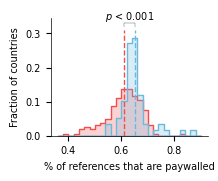

In [20]:
from scipy.stats import ttest_ind

bins = [x/100 for x in range(36, 92, 2)]

ax = plt.gca()

sns.histplot(
    countryOA, x="PercentNonOA", hue="GlobalSouth", element="step", bins=bins,
    stat="probability", common_norm=False, palette={True: '#f34d4d', False: '#69bade'}
)

whiteMean = countryOA.query('GlobalSouth==False').PercentNonOA.mean()
nonWhiteMean = countryOA.query('GlobalSouth==True').PercentNonOA.mean()

print(f'Global north average {whiteMean:.4f}, global south average {nonWhiteMean:.4f}')

plt.plot([whiteMean, whiteMean], [0, 0.31], color='#69bade', lw=1, ls='--')
plt.plot([nonWhiteMean, nonWhiteMean], [0, 0.31], color='#f34d4d', lw=1, ls='--')

tstat, p = ttest_ind(
    countryOA.query('GlobalSouth==False').PercentNonOA,
    countryOA.query('GlobalSouth==True').PercentNonOA
)

plotPvalue(ax, [whiteMean, nonWhiteMean], 0.31, pVal=p, gap=0.01, vlength=0.01)


set_size(4*cm, 3*cm, ax)

ax.set_xlabel('% of references that are paywalled')
ax.set_ylabel('Fraction of countries')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend([],[], frameon=False)

plt.savefig('../figures/nonOA_distribution.pdf',bbox_inches = 'tight', pad_inches = 0)

In [21]:
cohen_d(countryOA.query('GlobalSouth==False').PercentNonOA, countryOA.query('GlobalSouth==True').PercentNonOA)

0.6367521200157277

In [22]:
tstat

4.190961974311256

## Plot map

In [23]:
import math

def assignColor(row, col, baseline):
    try:
        diff = baseline-int(row[col]) # difference between the current bin and the baseline bin
        assert(4-diff >=0 and 4-diff < 10) # 10 being the total number of colors
        
        return colorSeq[4 - diff] # 4 is the index of the last green color
    except Exception as e:
        
        print('ERROR', e)
        return np.nan

def getPercentile(df, col, N, cutoff=None):
    
    # N: number of percentile bins
    # cutoff: below and above cutoff should be two different colors
    
    df = (
        df
        .assign(percentile = lambda df: 
                  df[col].rank(pct=True, method='max')
                  .apply(lambda x: math.ceil((x*N))) # round up percentile score
                 )
        .rename(columns={'percentile': f'{col}_Q'})
    )
    binsDf = None
    
    if cutoff is not None:
        
        # split the bin that contains cutoff into 2
        
        bins = df.groupby(f'{col}_Q')[col].max().reset_index().set_index(f'{col}_Q').to_dict()[col]
        
        ### add 1 as a bin cutoff, and shift all following bin index by 1 ###
        prev = None
        midInd = None # index of the last bin below cutoff
        
        for i in range(min(bins.keys()), N+1):
            if bins[i] > cutoff:
                if prev is None:
                    midInd = i
                    prev=bins[i]
                    bins[i] = cutoff
                else:
                    bins[i], prev = prev, bins[i]
        bins[N+1] = prev
        
        binsDf = (
            pd.DataFrame.from_dict(bins, orient='index', columns=[f'{col}_max'])
            .reset_index().rename(columns={'index': f'{col}_Q'})
            .assign(Color = lambda df: df.apply(lambda row: assignColor(row, f'{col}_Q', baseline=midInd), axis=1))
        )
        ######
        
        df = df.drop([f'{col}_Q'], axis=1)

        df = getColor(df, binsDf, col)
    
    return df, binsDf

def getColor(df, bins, col):

    cols = cols = df.columns.to_list()

    return (
        df
        .assign(key=1).merge(bins.assign(key=1), on='key')
        .query(f'{col} <= {col}_max')
        .groupby(cols)[f'{col}_Q'].min().reset_index()
        
        .merge(bins[[f'{col}_Q', 'Color']], on=f'{col}_Q')
    )

import geopandas

def produceMap(df, unit='country_code'):
    
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

    world = (
        geopandas.read_file(url)
        [['NAME','ISO_A3','ISO_A2','CONTINENT','geometry']]
        .rename(columns={'ISO_A3':'iso3','ISO_A2':'country_code','NAME':'name','CONTINENT':'continent'})
    )
    print(world.shape)

    world.loc[world.name == 'Taiwan', 'country_code'] = 'CN'
    world.loc[world.name == 'Norway', 'country_code'] = 'NO'
    world.loc[world.name == 'France', 'country_code'] = 'FR'

    world = (
        world.pipe(printShape, cols=['country_code'])

        .query('continent != "Antarctica"')
        .drop(['continent'], axis=1)
        .pipe(printShape, cols=['country_code'], msg='remove Antarctica')

        .query('country_code != "-99"')
        .pipe(printShape, cols=['country_code'], msg='remove unrecognized countries')

        .dissolve(by='country_code').reset_index()
        .pipe(printShape, cols=['country_code'], msg='one china')

        .merge(df, on='country_code')
        .pipe(printShape, cols=[unit, 'country_code'], msg='data to plot')
    )

    if unit != 'country_code':
        world = (
            world
            .dissolve(by=unit).reset_index()
            .pipe(printShape, cols=[unit], msg='aggregate within unit')

            [['geometry', unit]] 
        )
    
    return world

def plotMap(df, col, ax=None, numBins=5, colorCutoff=None, minTotal=100, cax=None, figsize=(24*cm, 6*cm)):
    
    world = produceMap(df)

    if colorCutoff is None:
        colorCutoff = world.query(f'Total >= {minTotal}')[col].median()
    
    relativeBins, bins = getPercentile(
        world.query(f'Total >= {minTotal}')[['country_code',col]],
        col, numBins, colorCutoff
    )
    
    assert(relativeBins.shape[0] ==  world.query(f'Total >= {minTotal}').shape[0])
    if numBins + 1 != bins.shape[0]:
        print('warning! number of bins', bins.shape[0])

    world = (
        pd.concat([
            world.query(f'Total >= {minTotal}').merge(relativeBins.drop([col], axis=1), on='country_code'),
            world.query(f'Total < {minTotal}').assign(Color='#eeeeee')
        ], ignore_index=True, sort=False)
    )

    print(world.shape, 'should be the same as before')

    if ax is None: ax = plt.gca()

    set_size(figsize[0], figsize[1], ax)

    world.plot(ax = ax, color=world.Color)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if cax is not None:
        plotPallete(bins.Color, list(bins.Relative_max), cax, vertical=True, scale=0.6)
    
    return bins, world

def plotPallete(cSeq, labels, ax=None, vertical=False, scale=1, rounding=1, minVal=0):
    
    n = len(cSeq)
    labels = [minVal] + labels
    
    if vertical:
        if ax is None:
            
            ax = plt.gca()
            set_size(1*cm*scale, n*cm*scale)
    
        ax.set_ylim(0, n)
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        ax.set_yticks([x for x in range(n+1)])
        ax.set_yticklabels([f"{round(x, rounding):g}" for x in labels])
        
        for i in range(n):
            ax.fill_between([0, 1], i, i+1, facecolor=cSeq[i])

In [24]:
colorSeq = [
    '#543005',
    '#8c510a',
    '#bf812d',
    '#dfc27d',
    '#f6e8c3',
    '#c7eae5',
    '#80cdc1',
    '#35978f',
    '#01665e',
    '#003c30'
]

len(colorSeq)

10

(177, 5)
(177, 5)  country_code 174  
(176, 4)  country_code 173  remove Antarctica
(173, 4)  country_code 172  remove unrecognized countries
(172, 4)  country_code 172  one china
(169, 14)  country_code 169  country_code 169  data to plot
(169, 16) should be the same as before


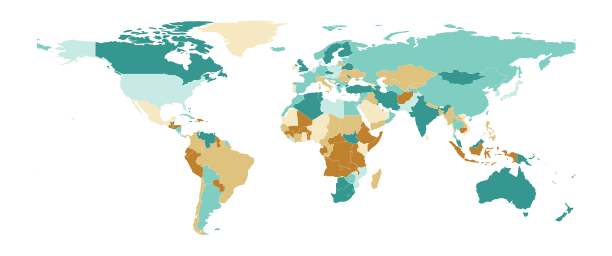

In [25]:
bins, worldMap = plotMap(countryOA, col='PercentNonOA', minTotal=100)

plt.savefig(f'../figures/OA_map_percentageNonOA.pdf',bbox_inches = 'tight', pad_inches = 0)

In [26]:
bins

,PercentNonOA_Q,PercentNonOA_max,Color
0,1,0.581815,#bf812d
1,2,0.616992,#dfc27d
2,3,0.628945,#f6e8c3
3,4,0.636160,#c7eae5
4,5,0.659945,#80cdc1
5,6,0.727759,#35978f


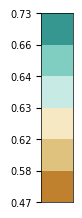

In [27]:
plotPallete(bins.Color, list(bins.PercentNonOA_max), vertical=True, scale=0.8, rounding=2, minVal=worldMap.PercentNonOA.min())

plt.savefig('../figures/map_legend.pdf', bbox_inches = 'tight', pad_inches = 0)